In [1]:
# Dependencies

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sn

import quandl
from config1 import quandl_api_key

from datetime import datetime
from datetime import date
from datetime import timedelta
from scipy.stats import linregress
from scipy.stats import zscore
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# API Calls to Quandl

# Treasury Yield Curve
try:
    treas_ylds = quandl.get("USTREASURY/YIELD", authtoken=quandl_api_key)
    treas_ylds.to_csv("quandl_data/treas_yld_curve.csv")
    print("Successfully downloaded and exported Treasury Yield Curve data")
    
except Exception as e:
    print(e)
    
# S&P 500 Monthly Dividend Yield
try:   
    sp500_div_yld = quandl.get("MULTPL/SP500_DIV_YIELD_MONTH", authtoken=quandl_api_key)
    sp500_div_yld.to_csv("quandl_data/sp500_div_yld.csv")
    print("Successfully downloaded and exported S&P 500 Monthly Dividend Yield data")
    
except Exception as e:
    print(e)   
    
# S&P 500 2-Month Futures
try:  
    sp500_1m = quandl.get("CHRIS/CME_ES2", authtoken=quandl_api_key) 
    sp500_1m.to_csv("quandl_data/sp500_2m.csv")
    print("Successfully downloaded and exported S&P 500 2-Month Futures data")

except Exception as e:
    print(e)
    
# TED Spread (3-Month LIBOR - 3-Month Treasury)
try:  
    ted_spread = quandl.get("FRED/TEDRATE", authtoken=quandl_api_key) 
    ted_spread.to_csv("quandl_data/ted_spread.csv")
    print("Successfully downloaded and exported TED Spread (3-Month LIBOR - 3-Month Treasury) data")

except Exception as e:
    print(e)

Successfully downloaded and exported Treasury Yield Curve data
Successfully downloaded and exported S&P 500 Monthly Dividend Yield data
Successfully downloaded and exported S&P 500 2-Month Futures data
Successfully downloaded and exported TED Spread (3-Month LIBOR - 3-Month Treasury) data


In [3]:
def df_datefilter(original_df, begin_date="1990-01-30", end_date=(date.today() - timedelta(1)).strftime("%Y-%m-%d")):
    
    sort_dates_df = original_df.loc[(original_df["Date"] >= begin_date) & (original_df["Date"] <= end_date)]

    return sort_dates_df

In [4]:
raw_sp500_df = sp500_1m[["Settle", "Open", "High", "Low", "Last"]].join(sp500_div_yld, how="outer").rename(columns={"Settle": "SP500", "Value": "Div Yld"})
raw_sp500_df

,SP500,Open,High,Low,Last,Div Yld
Date,,,,,,
1871-01-31,NaN,NaN,NaN,NaN,NaN,5.86
1871-02-28,NaN,NaN,NaN,NaN,NaN,5.78
1871-03-31,NaN,NaN,NaN,NaN,NaN,5.64
1871-04-30,NaN,NaN,NaN,NaN,NaN,5.49
1871-05-31,NaN,NaN,NaN,NaN,NaN,5.35
...,...,...,...,...,...,...
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,NaN
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,NaN
2020-07-10,3167.50,3138.00,3170.00,3101.25,3168.25,NaN


In [5]:
filtered_sp500_df = raw_sp500_df[raw_sp500_df["SP500"].notna()].copy()
filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "1990-01-30")]
filtered_sp500_df

,SP500,Open,High,Low,Last,Div Yld
Date,,,,,,
1997-09-09,944.00,943.50,951.00,941.50,944.00,NaN
1997-09-10,925.00,942.75,943.25,917.00,925.00,NaN
1997-09-11,918.25,924.00,929.75,910.25,918.25,NaN
1997-09-12,933.75,918.00,936.50,913.50,933.75,NaN
1997-09-15,931.50,933.50,939.75,929.00,931.50,NaN
...,...,...,...,...,...,...
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,NaN
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,NaN
2020-07-10,3167.50,3138.00,3170.00,3101.25,3168.25,NaN


In [6]:
#Calculate Daily Dividend Yield from the monthly value

div_yield_list = []
dollar_yield_list = []

dollar_yield = 0

for index, row in filtered_sp500_df.iterrows():
    price_row = row["SP500"]
    yield_row = row["Div Yld"]
    if yield_row > 0:
        div_yield_list.append(round(yield_row, 2))
        current_yield = yield_row
        dollar_yield = (current_yield / 100) * price_row
        dollar_yield_list.append(round(dollar_yield, 2))
    else:
        percent_yield = dollar_yield / price_row *100
        div_yield_list.append(round(percent_yield, 2))
    
print(len(div_yield_list))   

filtered_sp500_df["Div Yld"] = div_yield_list

filtered_sp500_df

5814


,SP500,Open,High,Low,Last,Div Yld
Date,,,,,,
1997-09-09,944.00,943.50,951.00,941.50,944.00,0.00
1997-09-10,925.00,942.75,943.25,917.00,925.00,0.00
1997-09-11,918.25,924.00,929.75,910.25,918.25,0.00
1997-09-12,933.75,918.00,936.50,913.50,933.75,0.00
1997-09-15,931.50,933.50,939.75,929.00,931.50,0.00
...,...,...,...,...,...,...
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,1.87
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,1.89
2020-07-10,3167.50,3138.00,3170.00,3101.25,3168.25,1.86


In [7]:
old_df_calcs = filtered_sp500_df.copy()

In [8]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [9]:
filtered_sp500_df["RSI"] = computeRSI(filtered_sp500_df["SP500"], 14)
filtered_sp500_df

,SP500,Open,High,Low,Last,Div Yld,RSI
Date,,,,,,,
1997-09-09,944.00,943.50,951.00,941.50,944.00,0.00,NaN
1997-09-10,925.00,942.75,943.25,917.00,925.00,0.00,NaN
1997-09-11,918.25,924.00,929.75,910.25,918.25,0.00,NaN
1997-09-12,933.75,918.00,936.50,913.50,933.75,0.00,NaN
1997-09-15,931.50,933.50,939.75,929.00,931.50,0.00,NaN
...,...,...,...,...,...,...,...
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,1.87,58.593155
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,1.89,55.993296
2020-07-10,3167.50,3138.00,3170.00,3101.25,3168.25,1.86,59.232743


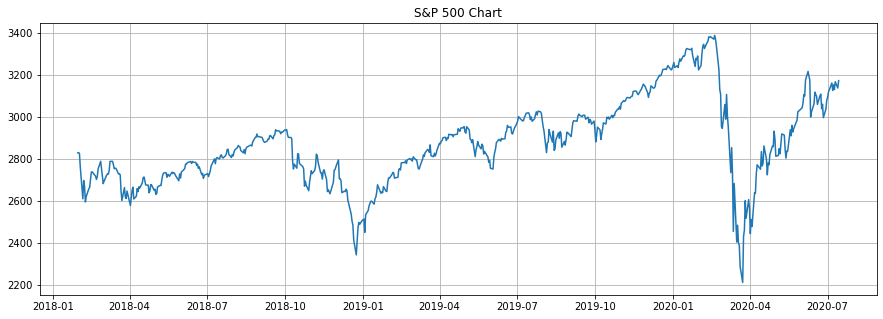

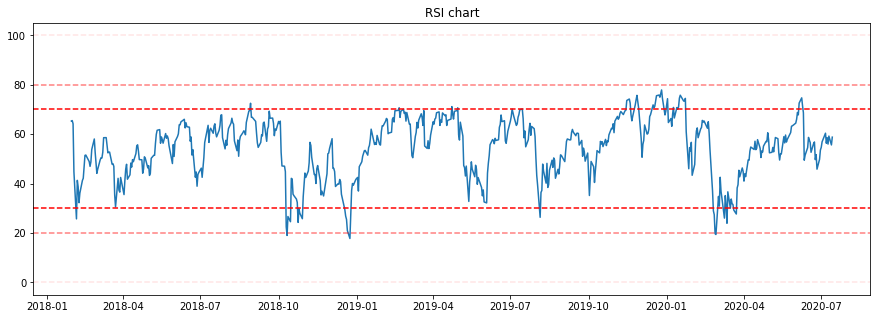

In [10]:
copy_filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "2018-01-30")].copy()
copy_filtered_sp500_df = copy_filtered_sp500_df.reset_index()

# plot price
plt.figure(figsize=(15,5))
plt.plot(copy_filtered_sp500_df['Date'], copy_filtered_sp500_df['SP500'])
plt.title('S&P 500 Chart')
plt.grid(alpha=1)
plt.show()


# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('RSI chart')
plt.plot(copy_filtered_sp500_df['Date'], copy_filtered_sp500_df['RSI'])

plt.axhline(0, linestyle='--', alpha=0.1, color="red")
plt.axhline(20, linestyle='--', alpha=0.5, color="red")
plt.axhline(30, linestyle='--', color="red")

plt.axhline(70, linestyle='--', color="red")
plt.axhline(80, linestyle='--', alpha=0.5, color="red")
plt.axhline(100, linestyle='--', alpha=0.1, color="red")
plt.show()

In [11]:
# 12-Day Weighted Moving Average (WMA)
weights = np.arange(1,13)
filtered_sp500_df["12-DayWMA"] = filtered_sp500_df["SP500"].rolling(12).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

# 12-Day Exponential Moving Everage (EMA): 12-Day SMA is first value
sma12 = filtered_sp500_df["SP500"].rolling(window=12).mean()
modPrice12 = filtered_sp500_df["SP500"].copy()
modPrice12.iloc[0:12] = sma12[0:12]
filtered_sp500_df["12-DayEMA"] = modPrice12.ewm(span=12).mean()

# 26-Day Exponential Moving Everage (EMA): 26-Day SMA is first value
sma26 = filtered_sp500_df["SP500"].rolling(window=26).mean()
modPrice26 = filtered_sp500_df["SP500"].copy()
modPrice26.iloc[0:26] = sma26[0:26]
filtered_sp500_df["26-DayEMA"] = modPrice26.ewm(span=26).mean()

# 50, 100, and 200 Day Moving Average (SMA)
filtered_sp500_df["50-DaySMA"] = filtered_sp500_df["SP500"].rolling(window=50).mean()
filtered_sp500_df["100-DaySMA"] = filtered_sp500_df["SP500"].rolling(window=100).mean()
filtered_sp500_df["200-DaySMA"] = filtered_sp500_df["SP500"].rolling(window=200).mean()
#filtered_sp500_df["Expo20-DayMA"] = filtered_sp500_df["Last"].ewm(halflife=0.5, min_periods=20).mean()
filtered_sp500_df

,SP500,Open,High,Low,Last,Div Yld,RSI,12-DayWMA,12-DayEMA,26-DayEMA,50-DaySMA,100-DaySMA,200-DaySMA
Date,,,,,,,,,,,,,
1997-09-09,944.00,943.50,951.00,941.50,944.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-10,925.00,942.75,943.25,917.00,925.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-11,918.25,924.00,929.75,910.25,918.25,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-12,933.75,918.00,936.50,913.50,933.75,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-15,931.50,933.50,939.75,929.00,931.50,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,1.87,58.593155,3103.714744,3103.923427,3072.917557,3007.825,2895.2100,3018.48000
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,1.89,55.993296,3110.009615,3108.012130,3077.182923,3013.255,2892.7000,3019.13625
2020-07-10,3167.50,3138.00,3170.00,3101.25,3168.25,1.86,59.232743,3121.618590,3117.164110,3083.873077,3017.955,2890.6775,3020.11250


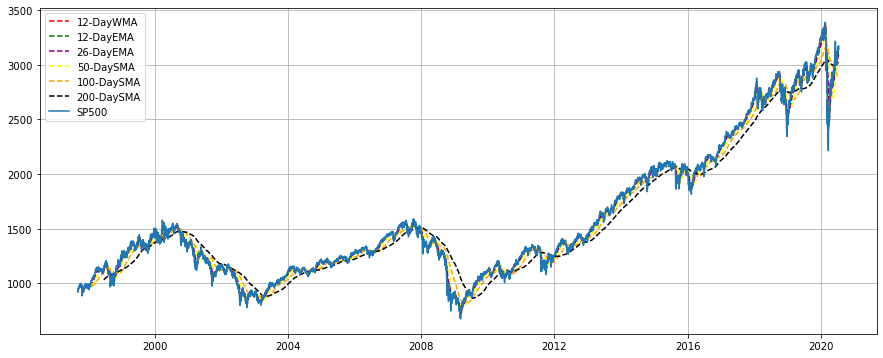

In [12]:
copysma_filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "1990-01-30")].copy()
copysma_filtered_sp500_df = copysma_filtered_sp500_df#.reset_index()

plt.figure(figsize=(15,6))

plt.plot(copysma_filtered_sp500_df['12-DayWMA'], '--', label="12-DayWMA", color="red")
plt.plot(copysma_filtered_sp500_df['12-DayEMA'], '--', label="12-DayEMA", color="green")
plt.plot(copysma_filtered_sp500_df['26-DayEMA'], '--', label="26-DayEMA", color="purple")

plt.plot(copysma_filtered_sp500_df['50-DaySMA'], '--', label="50-DaySMA", color="yellow")
plt.plot(copysma_filtered_sp500_df['100-DaySMA'], '--', label="100-DaySMA", color="orange")
plt.plot(copysma_filtered_sp500_df['200-DaySMA'], '--', label="200-DaySMA", color="black")
plt.plot(copysma_filtered_sp500_df["SP500"], label="SP500")

plt.grid(alpha=1)
plt.legend()
plt.show()

In [13]:
filtered_sp500_df['3Std_Upper'] = filtered_sp500_df["SP500"].rolling(window=20).mean() + filtered_sp500_df["SP500"].rolling(window=20).std()*3
filtered_sp500_df['2Std_Upper'] = filtered_sp500_df["SP500"].rolling(window=20).mean() + filtered_sp500_df["SP500"].rolling(window=20).std()*2
filtered_sp500_df['Middle_20Day'] = filtered_sp500_df["SP500"].rolling(window=20).mean()
filtered_sp500_df['2Std_Lower'] = filtered_sp500_df["SP500"].rolling(window=20).mean() - filtered_sp500_df["SP500"].rolling(window=20).std()*2
filtered_sp500_df['3Std_Lower'] = filtered_sp500_df["SP500"].rolling(window=20).mean() - filtered_sp500_df["SP500"].rolling(window=20).std()*3
filtered_sp500_df

,SP500,Open,High,Low,Last,Div Yld,RSI,12-DayWMA,12-DayEMA,26-DayEMA,50-DaySMA,100-DaySMA,200-DaySMA,3Std_Upper,2Std_Upper,Middle_20Day,2Std_Lower,3Std_Lower
Date,,,,,,,,,,,,,,,,,,
1997-09-09,944.00,943.50,951.00,941.50,944.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-10,925.00,942.75,943.25,917.00,925.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-11,918.25,924.00,929.75,910.25,918.25,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-12,933.75,918.00,936.50,913.50,933.75,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-15,931.50,933.50,939.75,929.00,931.50,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,1.87,58.593155,3103.714744,3103.923427,3072.917557,3007.825,2895.2100,3018.48000,3238.350411,3187.541941,3085.9250,2984.308059,2933.499589
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,1.89,55.993296,3110.009615,3108.012130,3077.182923,3013.255,2892.7000,3019.13625,3226.244394,3178.721263,3083.6750,2988.628737,2941.105606
2020-07-10,3167.50,3138.00,3170.00,3101.25,3168.25,1.86,59.232743,3121.618590,3117.164110,3083.873077,3017.955,2890.6775,3020.11250,3232.181090,3185.479060,3092.0750,2998.670940,2951.968910


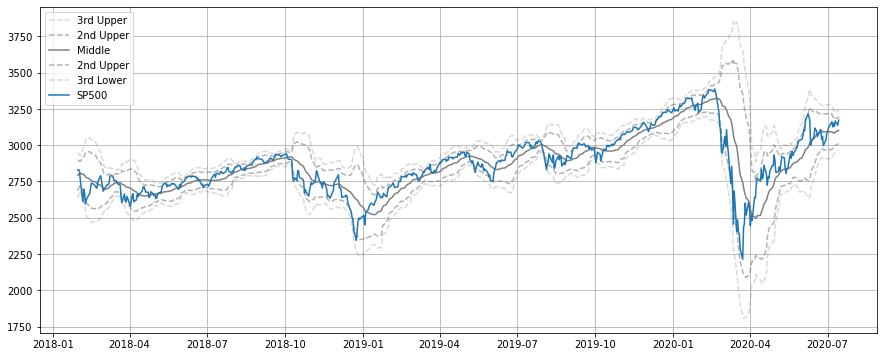

In [14]:
copyBB_filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "2018-01-30")].copy()
copyBB_filtered_sp500_df = copyBB_filtered_sp500_df#.reset_index()

plt.figure(figsize=(15,6))
plt.plot(copyBB_filtered_sp500_df['3Std_Upper'], '--', label="3rd Upper", color="grey", alpha=0.3)
plt.plot(copyBB_filtered_sp500_df['2Std_Upper'], '--', label="2nd Upper", color="grey", alpha=0.6)
plt.plot(copyBB_filtered_sp500_df['Middle_20Day'], '-', label="Middle", color="grey")
plt.plot(copyBB_filtered_sp500_df['2Std_Lower'], '--', label="2nd Upper", color="grey", alpha=0.6)
plt.plot(copyBB_filtered_sp500_df['3Std_Lower'], '--', label="3rd Lower", color="grey", alpha=0.3)
plt.plot(copyBB_filtered_sp500_df["SP500"], label="SP500")
plt.grid(alpha=1)
plt.legend()
plt.show()

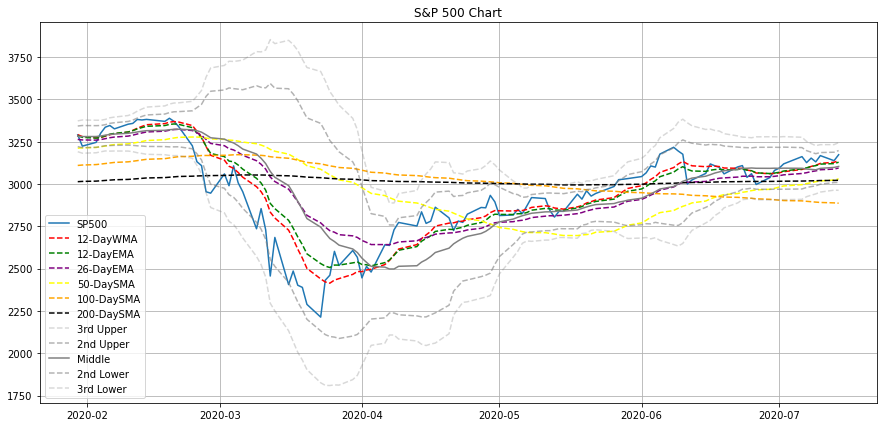

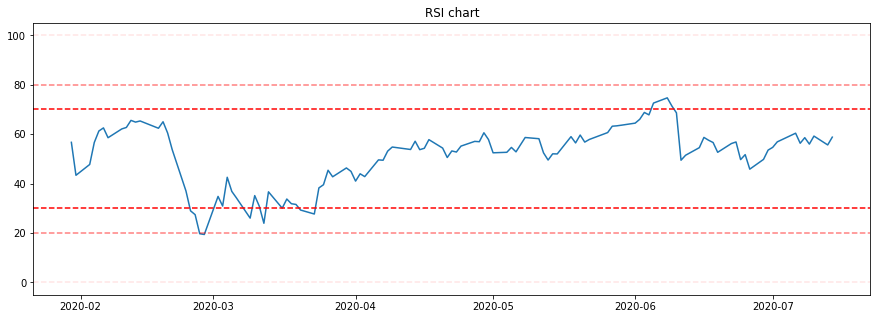

In [15]:
all_filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "2020-01-30")].copy()
all_filtered_sp500_df = all_filtered_sp500_df#.reset_index()

# plot price
plt.figure(figsize=(15,7))
plt.plot(all_filtered_sp500_df['SP500'], label="SP500")
plt.plot(all_filtered_sp500_df['12-DayWMA'], '--', label="12-DayWMA", color="red")
plt.plot(all_filtered_sp500_df['12-DayEMA'], '--', label="12-DayEMA", color="green")
plt.plot(all_filtered_sp500_df['26-DayEMA'], '--', label="26-DayEMA", color="purple")
plt.plot(all_filtered_sp500_df['50-DaySMA'], '--', label="50-DaySMA", color="yellow")
plt.plot(all_filtered_sp500_df['100-DaySMA'], '--', label="100-DaySMA", color="orange")
plt.plot(all_filtered_sp500_df['200-DaySMA'], '--', label="200-DaySMA", color="black")
plt.plot(all_filtered_sp500_df['3Std_Upper'], '--', label="3rd Upper", color="grey", alpha=0.3)
plt.plot(all_filtered_sp500_df['2Std_Upper'], '--', label="2nd Upper", color="grey", alpha=0.6)
plt.plot(all_filtered_sp500_df['Middle_20Day'], '-', label="Middle", color="grey")
plt.plot(all_filtered_sp500_df['2Std_Lower'], '--', label="2nd Lower", color="grey", alpha=0.6)
plt.plot(all_filtered_sp500_df['3Std_Lower'], '--', label="3rd Lower", color="grey", alpha=0.3)
plt.title('S&P 500 Chart')
plt.grid(alpha=1)
plt.legend()
plt.show()


# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('RSI chart')
plt.plot(all_filtered_sp500_df['RSI'])

plt.axhline(0, linestyle='--', alpha=0.1, color="red")
plt.axhline(20, linestyle='--', alpha=0.5, color="red")
plt.axhline(30, linestyle='--', color="red")

plt.axhline(70, linestyle='--', color="red")
plt.axhline(80, linestyle='--', alpha=0.5, color="red")
plt.axhline(100, linestyle='--', alpha=0.1, color="red")
plt.show()

In [16]:
filtered_sp500_df["12WMA%12EMA"] = (filtered_sp500_df["12-DayWMA"] - filtered_sp500_df["12-DayEMA"])/filtered_sp500_df["12-DayEMA"]*100
filtered_sp500_df["12WMA%26EMA"] = (filtered_sp500_df["12-DayWMA"] - filtered_sp500_df["26-DayEMA"])/filtered_sp500_df["26-DayEMA"]*100
filtered_sp500_df["12EMA%26EMA"] = (filtered_sp500_df["12-DayEMA"] - filtered_sp500_df["26-DayEMA"])/filtered_sp500_df["26-DayEMA"]*100

filtered_sp500_df["50SMA%100SMA"] = (filtered_sp500_df["50-DaySMA"] - filtered_sp500_df["100-DaySMA"])/filtered_sp500_df["100-DaySMA"]*100
filtered_sp500_df["50SMA%200SMA"] = (filtered_sp500_df["50-DaySMA"] - filtered_sp500_df["200-DaySMA"])/filtered_sp500_df["200-DaySMA"]*100
filtered_sp500_df["100SMA%200SMA"] = (filtered_sp500_df["100-DaySMA"] - filtered_sp500_df["200-DaySMA"])/filtered_sp500_df["200-DaySMA"]*100

filtered_sp500_df["SP500%12WMA"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["12-DayWMA"])/filtered_sp500_df["12-DayWMA"]*100
filtered_sp500_df["SP500%12EMA"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["12-DayEMA"])/filtered_sp500_df["12-DayEMA"]*100
filtered_sp500_df["SP500%26EMA"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["26-DayEMA"])/filtered_sp500_df["26-DayEMA"]*100

filtered_sp500_df["SP500%50SMA"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["50-DaySMA"])/filtered_sp500_df["50-DaySMA"]*100
filtered_sp500_df["SP500%100SMA"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["100-DaySMA"])/filtered_sp500_df["100-DaySMA"]*100
filtered_sp500_df["SP500%200SMA"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["200-DaySMA"])/filtered_sp500_df["200-DaySMA"]*100

filtered_sp500_df["SP500%3Upper"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["3Std_Upper"])/filtered_sp500_df["3Std_Upper"]*100
filtered_sp500_df["SP500%2Upper"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["2Std_Upper"])/filtered_sp500_df["2Std_Upper"]*100
filtered_sp500_df["SP500%Middle20Day"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["Middle_20Day"])/filtered_sp500_df["Middle_20Day"]*100
filtered_sp500_df["SP500%2Lower"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["2Std_Lower"])/filtered_sp500_df["2Std_Lower"]*100
filtered_sp500_df["SP500%3Lower"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["3Std_Lower"])/filtered_sp500_df["3Std_Lower"]*100

filtered_sp500_df

,SP500,Open,High,Low,Last,Div Yld,RSI,12-DayWMA,12-DayEMA,26-DayEMA,...,SP500%12EMA,SP500%26EMA,SP500%50SMA,SP500%100SMA,SP500%200SMA,SP500%3Upper,SP500%2Upper,SP500%Middle20Day,SP500%2Lower,SP500%3Lower
Date,,,,,,,,,,,,,,,,,,,,,
1997-09-09,944.00,943.50,951.00,941.50,944.00,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-10,925.00,942.75,943.25,917.00,925.00,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-11,918.25,924.00,929.75,910.25,918.25,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-12,933.75,918.00,936.50,913.50,933.75,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-15,931.50,933.50,939.75,929.00,931.50,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,1.87,58.593155,3103.714744,3103.923427,3072.917557,...,1.573060,2.597936,4.818266,8.895382,4.448265,-2.643334,-1.091498,2.165477,5.644254,7.474022
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,1.89,55.993296,3110.009615,3108.012130,3077.182923,...,0.723545,1.732659,3.890975,8.220693,3.688596,-2.967673,-1.517002,1.518480,4.747035,6.439565
2020-07-10,3167.50,3138.00,3170.00,3101.25,3168.25,1.86,59.232743,3121.618590,3117.164110,3083.873077,...,1.614798,2.711750,4.955177,9.576388,4.880199,-2.001159,-0.564407,2.439300,5.630130,7.301266


In [17]:
old_df_calcs = old_df_calcs.join(treas_ylds, how="left")
old_df_calcs = old_df_calcs[old_df_calcs["SP500"].notna()].copy()
old_df_calcs = old_df_calcs.drop(columns=["Open", "High", "Low", "Last", "1 MO", "2 MO", "1 YR", "3 YR", "5 YR", "7 YR", "20 YR", "30 YR"])

old_df_calcs["6Mo - 3Mo"] = old_df_calcs["6 MO"] - old_df_calcs["3 MO"]
old_df_calcs

,SP500,Div Yld,3 MO,6 MO,2 YR,10 YR,6Mo - 3Mo
Date,,,,,,,
1997-09-09,944.00,0.00,5.16,5.35,5.98,6.34,0.19
1997-09-10,925.00,0.00,5.11,5.35,6.00,6.37,0.24
1997-09-11,918.25,0.00,5.13,5.36,6.00,6.39,0.23
1997-09-12,933.75,0.00,5.10,5.32,5.93,6.29,0.22
1997-09-15,931.50,0.00,5.08,5.31,5.93,6.28,0.23
...,...,...,...,...,...,...,...
2020-07-08,3152.75,1.87,0.15,0.17,0.16,0.67,0.02
2020-07-09,3130.50,1.89,0.13,0.16,0.16,0.62,0.03
2020-07-10,3167.50,1.86,0.13,0.15,0.16,0.65,0.02


In [18]:
def df_returns(original_df, begin_date="1990-01-30", end_date=(date.today() - timedelta(1)).strftime("%Y-%m-%d"), add_text="% Ret"):
    
    sort_dates_df = original_df.loc[(original_df.index >= begin_date) & (original_df.index <= end_date)]
    
    col_titles = list(sort_dates_df)

    returns = sort_dates_df[col_titles[0]] / sort_dates_df[col_titles[0]].shift(1)-1

    perc_ret_df = pd.DataFrame({f"{col_titles[0]} {add_text}": round(returns * 100, 2)})

    for title in col_titles[1:]:
        returns = sort_dates_df[title] / sort_dates_df[title].shift(1)-1
        perc_ret_df[f"{title} {add_text}"] = round(returns * 100, 2)
    
    perc_ret_df = perc_ret_df.replace([np.inf, -np.inf], 0)
    return perc_ret_df

In [19]:
df_calcs = df_returns(old_df_calcs)
new_calcs = old_df_calcs[["SP500"]].copy()
new_calcs["6Mo - 3Mo % Ret"] = df_calcs["6Mo - 3Mo % Ret"]
new_calcs
print(new_calcs.isnull().sum())
new_calcs.dropna(inplace=True)
print(new_calcs.isnull().sum())
new_calcs

SP500                0
6Mo - 3Mo % Ret    233
dtype: int64
SP500              0
6Mo - 3Mo % Ret    0
dtype: int64


,SP500,6Mo - 3Mo % Ret
Date,,
1997-09-10,925.00,26.32
1997-09-11,918.25,-4.17
1997-09-12,933.75,-4.35
1997-09-15,931.50,4.55
1997-09-16,956.00,-17.39
...,...,...
2020-07-07,3126.00,100.00
2020-07-08,3152.75,0.00
2020-07-09,3130.50,50.00


In [20]:
def df_corr_analysis(original_df, begin_date="1990-01-30", end_date=(date.today() - timedelta(1)).strftime("%Y-%m-%d")):
    
    sort_dates_df = original_df.loc[(original_df.index >= begin_date) & (original_df.index <= end_date)]
    
    col_titles = list(sort_dates_df)

    perc_ret_df = pd.DataFrame({f"{col_titles[0]}": sort_dates_df[col_titles[0]]})

    for title in col_titles[1:]:
        correlation = sort_dates_df[col_titles[0]].rolling(100).corr(sort_dates_df[title])
        perc_ret_df[f"{col_titles[0]} corr {title}"] = correlation

    perc_ret_df = perc_ret_df.replace([np.inf, -np.inf], 0)

    return perc_ret_df

In [21]:
new_calcs = df_corr_analysis(new_calcs)
new_calcs

,SP500,SP500 corr 6Mo - 3Mo % Ret
Date,,
1997-09-10,925.00,NaN
1997-09-11,918.25,NaN
1997-09-12,933.75,NaN
1997-09-15,931.50,NaN
1997-09-16,956.00,NaN
...,...,...
2020-07-07,3126.00,0.170976
2020-07-08,3152.75,0.161491
2020-07-09,3130.50,0.178354


In [22]:
new_calcs["Div/10Yr-2Yr"] = old_df_calcs["Div Yld"] / (old_df_calcs["10 YR"] - old_df_calcs["2 YR"])
new_calcs

,SP500,SP500 corr 6Mo - 3Mo % Ret,Div/10Yr-2Yr
Date,,,
1997-09-10,925.00,NaN,0.000000
1997-09-11,918.25,NaN,0.000000
1997-09-12,933.75,NaN,0.000000
1997-09-15,931.50,NaN,0.000000
1997-09-16,956.00,NaN,0.000000
...,...,...,...
2020-07-07,3126.00,0.170976,3.857143
2020-07-08,3152.75,0.161491,3.666667
2020-07-09,3130.50,0.178354,4.108696


In [23]:
filtered_sp500_df["Div/10Yr-2Yr"] = new_calcs["Div/10Yr-2Yr"]
filtered_sp500_df["SP500 corr 6Mo - 3Mo % Ret"] = new_calcs["SP500 corr 6Mo - 3Mo % Ret"]
filtered_sp500_df

,SP500,Open,High,Low,Last,Div Yld,RSI,12-DayWMA,12-DayEMA,26-DayEMA,...,SP500%50SMA,SP500%100SMA,SP500%200SMA,SP500%3Upper,SP500%2Upper,SP500%Middle20Day,SP500%2Lower,SP500%3Lower,Div/10Yr-2Yr,SP500 corr 6Mo - 3Mo % Ret
Date,,,,,,,,,,,,,,,,,,,,,
1997-09-09,944.00,943.50,951.00,941.50,944.00,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-10,925.00,942.75,943.25,917.00,925.00,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1997-09-11,918.25,924.00,929.75,910.25,918.25,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1997-09-12,933.75,918.00,936.50,913.50,933.75,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1997-09-15,931.50,933.50,939.75,929.00,931.50,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,1.87,58.593155,3103.714744,3103.923427,3072.917557,...,4.818266,8.895382,4.448265,-2.643334,-1.091498,2.165477,5.644254,7.474022,3.666667,0.161491
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,1.89,55.993296,3110.009615,3108.012130,3077.182923,...,3.890975,8.220693,3.688596,-2.967673,-1.517002,1.518480,4.747035,6.439565,4.108696,0.178354
2020-07-10,3167.50,3138.00,3170.00,3101.25,3168.25,1.86,59.232743,3121.618590,3117.164110,3083.873077,...,4.955177,9.576388,4.880199,-2.001159,-0.564407,2.439300,5.630130,7.301266,3.795918,0.175833


In [24]:
print(filtered_sp500_df.isnull().sum())
filtered_sp500_df.dropna(inplace=True)
print(filtered_sp500_df.isnull().sum())
filtered_sp500_df

SP500                           0
Open                            0
High                            0
Low                             0
Last                            0
Div Yld                         0
RSI                            14
12-DayWMA                      11
12-DayEMA                      11
26-DayEMA                      25
50-DaySMA                      49
100-DaySMA                     99
200-DaySMA                    199
3Std_Upper                     19
2Std_Upper                     19
Middle_20Day                   19
2Std_Lower                     19
3Std_Lower                     19
12WMA%12EMA                    11
12WMA%26EMA                    25
12EMA%26EMA                    25
50SMA%100SMA                   99
50SMA%200SMA                  199
100SMA%200SMA                 199
SP500%12WMA                    11
SP500%12EMA                    11
SP500%26EMA                    25
SP500%50SMA                    49
SP500%100SMA                   99
SP500%200SMA  

,SP500,Open,High,Low,Last,Div Yld,RSI,12-DayWMA,12-DayEMA,26-DayEMA,...,SP500%50SMA,SP500%100SMA,SP500%200SMA,SP500%3Upper,SP500%2Upper,SP500%Middle20Day,SP500%2Lower,SP500%3Lower,Div/10Yr-2Yr,SP500 corr 6Mo - 3Mo % Ret
Date,,,,,,,,,,,,,,,,,,,,,
1998-06-22,1128.00,1122.50,1132.25,1122.50,1128.00,1.42,54.352587,1114.596154,1115.265675,1116.319239,...,0.504751,2.702543,9.250056,-1.887951,-0.823519,1.376173,3.675653,4.864961,-23.666667,-0.062412
1998-06-23,1140.25,1130.00,1143.25,1130.00,1140.25,1.41,58.187874,1118.237179,1119.109418,1118.091891,...,1.575862,3.681005,10.331648,-1.314983,-0.131021,2.324225,4.903236,6.242116,-35.250000,-0.058159
1998-06-24,1154.00,1141.00,1157.25,1140.25,1154.00,1.39,62.042890,1123.849359,1124.477200,1120.751754,...,2.766869,4.800242,11.538536,-0.969337,0.429224,3.348297,6.442141,8.059582,-46.333333,-0.064330
1998-06-25,1152.50,1160.75,1166.00,1152.50,1152.50,1.39,61.378060,1128.919872,1128.788400,1123.103478,...,2.607705,4.538703,11.267594,-1.726144,-0.194098,3.017911,6.443535,8.243226,-19.857143,-0.051034
1998-06-26,1161.00,1154.50,1161.00,1153.25,1161.00,1.38,63.748642,1135.035256,1133.744030,1125.910631,...,3.300546,5.176143,11.965398,-1.765028,-0.056179,3.546305,7.418204,9.464808,-27.600000,-0.051428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-07,3126.00,3158.25,3173.50,3122.75,3125.00,1.89,56.329496,3092.801282,3095.045868,3066.530962,...,4.130926,7.887505,3.590070,-3.853678,-2.216768,1.230160,4.928981,6.881640,3.857143,0.170976
2020-07-08,3152.75,3124.75,3154.75,3115.25,3154.50,1.87,58.593155,3103.714744,3103.923427,3072.917557,...,4.818266,8.895382,4.448265,-2.643334,-1.091498,2.165477,5.644254,7.474022,3.666667,0.161491
2020-07-09,3130.50,3158.50,3160.00,3095.00,3131.75,1.89,55.993296,3110.009615,3108.012130,3077.182923,...,3.890975,8.220693,3.688596,-2.967673,-1.517002,1.518480,4.747035,6.439565,4.108696,0.178354


In [25]:
list(filtered_sp500_df)

['SP500',
 'Open',
 'High',
 'Low',
 'Last',
 'Div Yld',
 'RSI',
 '12-DayWMA',
 '12-DayEMA',
 '26-DayEMA',
 '50-DaySMA',
 '100-DaySMA',
 '200-DaySMA',
 '3Std_Upper',
 '2Std_Upper',
 'Middle_20Day',
 '2Std_Lower',
 '3Std_Lower',
 '12WMA%12EMA',
 '12WMA%26EMA',
 '12EMA%26EMA',
 '50SMA%100SMA',
 '50SMA%200SMA',
 '100SMA%200SMA',
 'SP500%12WMA',
 'SP500%12EMA',
 'SP500%26EMA',
 'SP500%50SMA',
 'SP500%100SMA',
 'SP500%200SMA',
 'SP500%3Upper',
 'SP500%2Upper',
 'SP500%Middle20Day',
 'SP500%2Lower',
 'SP500%3Lower',
 'Div/10Yr-2Yr',
 'SP500 corr 6Mo - 3Mo % Ret']

In [123]:
sp500return_df = raw_sp500_df[raw_sp500_df["SP500"].notna()].copy()
sp500return_df = sp500return_df[["SP500"]].loc[(sp500return_df.index >= "1990-01-30")]
sp500return_df

,SP500
Date,
1997-09-09,944.00
1997-09-10,925.00
1997-09-11,918.25
1997-09-12,933.75
1997-09-15,931.50
...,...
2020-07-08,3152.75
2020-07-09,3130.50
2020-07-10,3167.50


In [133]:
def sp500_return(df, period=1):
    new_df = (df.shift(-period) - df) / df * 100
    return new_df

In [146]:
sp500_return(sp500return_df, 5)

,SP500
Date,
1997-09-09,1.271186
1997-09-10,3.351351
1997-09-11,4.301661
1997-09-12,3.989290
1997-09-15,4.857756
...,...
2020-07-08,NaN
2020-07-09,NaN
2020-07-10,NaN
